In [117]:
import numpy as np
from scipy.stats import skewnorm, skew
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, accuracy_score

def simulate_data(classes, n_vars, n, max_mu, max_sigma, max_skew):
    #The multivariate skew normal number generator
    def rng(mu, sigma, skew, n=1):
        k = len(mu)
        if not (k == len(sigma) and k ==len(skew)): 
            raise Exception("Mu, Sigma and Skew should be same length")

        data = np.zeros((int(n),k))

        for i in range(k):
            data[:,i] = skewnorm.rvs(skew[i], loc=mu[i], scale=sigma[i], size=int(n)) 

        return data
    
    if(np.sum(classes) != 1):
        raise Exception("Classes dont sum up to 1")
        
    n_classes = len(classes)
    sigma = np.random.randint(1,max_sigma,n_vars)
    skew = np.random.randint(-max_skew,max_skew,n_vars)
    mu =  np.random.randint(-max_mu, max_mu, (n_classes, n_vars))
    
    n_obs_class = np.round(np.dot(classes,n))
    
    data = np.zeros((int(np.sum(n_obs_class)),n_vars+1))
    for i in range(n_classes):
        #calculate indexes
        start = int(np.sum(n_obs_class[0:i]))
        end = int(np.sum(n_obs_class[0:i+1]))
        
        #set the data
        data[start:end,0] = i
        data[start:end,1:] = rng(mu[i,:], sigma, skew, n_obs_class[i])
        
    X = data[:,1:]
    y = data[:,0]
    
    columns = ["x"+str(x) for x in range(n_vars + 1)]
    columns[0] = "class"
    
    df = pd.DataFrame(data,columns=columns)
    df["class"] = df["class"].astype(int)
    return X,y, df



#parameters
classes = [0.2, 0.2, 0.3, 0.3] #percentages
n_vars = 30
n = 200000
max_mu = 2
max_sigma = 30
max_skew = 2
np.random.seed(12345)

#generate data
X,y, df = simulate_data(classes, n_vars, n, max_mu, max_sigma, max_skew)

display(df.groupby(["class"]).agg(["count", "mean", "var"]))

#make train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


accuracies = pd.DataFrame(columns=['method', 'accuracy', 'predictions'])

x1                         x2                          x3            \
       count      mean       var  count      mean        var  count      mean   
class                                                                           
0      40000  2.707013  6.209419  40000  1.367977  24.802024  40000 -1.128958   
1      40000 -0.320390  6.128702  40000  3.392172  24.727228  40000 -3.133036   
2      60000  0.690675  6.064000  60000  3.400183  24.342129  60000 -3.125112   
3      60000  2.692292  6.202771  60000  4.391699  24.410762  60000 -1.118992   

                    x4  ...         x27    x28                         x29  \
            var  count  ...         var  count      mean        var  count   
class                   ...                                                  
0      2.713693  40000  ...  145.840078  40000 -6.700770  31.477224  40000   
1      2.730170  40000  ...  144.897888  40000 -4.683212  31.410458  40000   
2      2.715301  60000  ...  142.987809  60000 -7.678473  31.385695  60000   
3      2.724760  60000  ...  144.940459  60000 -6.702301  31.294654  60000   

                                x30                         
            mean         var  count       mean         var  
class                                                       
0     -12.547654  392.361092  40000  15.393484  424.930042  
1     -15.417826  388.455804  40000  14.077013  423.016093  
2     -15.546376  396.141843  60000  14.078771  424.401426  
3     -13.377429  390.540687  60000  14.183920  426.134749  

[4 rows x 90 columns]

LDA Test accuracy 0.6707575757575758
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.71     13151
         1.0       0.65      0.60      0.63     13031
         2.0       0.62      0.63      0.63     19768
         3.0       0.70      0.73      0.72     20050

   micro avg       0.67      0.67      0.67     66000
   macro avg       0.67      0.67      0.67     66000
weighted avg       0.67      0.67      0.67     66000



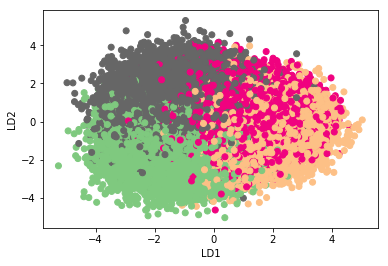

In [118]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(priors=classes)
X_lda = lda.fit_transform(X_train, y_train)



lda_pred = lda.predict(X_test)
lda_acc = accuracy_score(y_test, lda_pred)
print("LDA Test accuracy "+ str(lda_acc))
# confusion_matrix(y_test, lda_pred)
print(classification_report(y_test, lda_pred))

accuracies = accuracies.append({"method": "LDA", 
                   "accuracy":lda_acc, 
                   "predictions":lda_pred}, 
                    ignore_index=True)



plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=y_train,
    cmap='Accent',
#      alpha=0.7,
#      edgecolors='grey'
)

In [119]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)


clf_pred = clf.predict(X_test)
clf_acc = accuracy_score(y_test, clf_pred)
print("Logistic Test accuracy "+ str(clf_acc))

accuracies = accuracies.append({"method": "Logit", 
                   "accuracy":clf_acc, 
                   "predictions":clf_pred}, 
                    ignore_index=True)

# confusion_matrix(y_test, lda_pred)
print(classification_report(y_test, clf_pred))

# plt.xlabel('LD1')
# plt.ylabel('LD2')
# plt.scatter(
#     clf[:,0],
#     clf[:,1],
#     c=y_train,
#     cmap='Accent',
# #      alpha=0.7,
# #      edgecolors='grey'
# )

Logistic Test accuracy 0.669530303030303
              precision    recall  f1-score   support

         0.0       0.70      0.71      0.71     13151
         1.0       0.66      0.59      0.62     13031
         2.0       0.62      0.64      0.63     19768
         3.0       0.70      0.73      0.72     20050

   micro avg       0.67      0.67      0.67     66000
   macro avg       0.67      0.67      0.67     66000
weighted avg       0.67      0.67      0.67     66000



C:\Users\Tim\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [120]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(n_vars,), name='obs')
x = layers.Dense(40, activation='relu')(inputs)
x = layers.Dense(40, activation='relu')(x)
x = layers.Dense(40, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='Dataset')

display(model.summary())


model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

accuracies = accuracies.append({"method": "Neural Net", 
                   "accuracy": test_scores[1], 
                   "predictions":clf_pred}, 
                    ignore_index=True)

Model: "Dataset"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
obs (InputLayer)             [(None, 30)]              0         
_________________________________________________________________
dense_84 (Dense)             (None, 40)                1240      
_________________________________________________________________
dense_85 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_86 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_87 (Dense)             (None, 10)                410       
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________


None

Train on 107200 samples, validate on 26800 samples
Epoch 1/20
107200/107200 [==============================] - 9s 83us/sample - loss: 1.0436 - accuracy: 0.5586 - val_loss: 0.8552 - val_accuracy: 0.6446
Epoch 2/20
107200/107200 [==============================] - 8s 79us/sample - loss: 0.8436 - accuracy: 0.6511 - val_loss: 0.8226 - val_accuracy: 0.6577
Epoch 3/20
107200/107200 [==============================] - 9s 82us/sample - loss: 0.8299 - accuracy: 0.6573 - val_loss: 0.8160 - val_accuracy: 0.6624
Epoch 4/20
107200/107200 [==============================] - 9s 87us/sample - loss: 0.8243 - accuracy: 0.6600 - val_loss: 0.8178 - val_accuracy: 0.6606
Epoch 5/20
107200/107200 [==============================] - 9s 88us/sample - loss: 0.8201 - accuracy: 0.6611 - val_loss: 0.8177 - val_accuracy: 0.6584
Epoch 6/20
107200/107200 [==============================] - 9s 85us/sample - loss: 0.8166 - accuracy: 0.6626 - val_loss: 0.8188 - val_accuracy: 0.6621
Epoch 7/20
107200/107200 [=================

In [99]:
accuracies


,method,accuracy,predictions
0,LDA,0.649394,"[3.0, 2.0, 0.0, 2.0, 3.0, 2.0, 0.0, 2.0, 3.0, ..."
1,Logit,0.645455,"[3.0, 2.0, 0.0, 2.0, 3.0, 2.0, 0.0, 2.0, 3.0, ..."
2,Neural Net,0.613939,"[3.0, 2.0, 0.0, 2.0, 3.0, 2.0, 0.0, 2.0, 3.0, ..."


In [105]:
accuracies

,method,accuracy,predictions
0,LDA,0.655515,"[3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, ..."
1,Logit,0.653303,"[3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, ..."
2,Neural Net,0.658970,"[3.0, 3.0, 2.0, 3.0, 3.0, 2.0, 3.0, 3.0, 2.0, ..."


In [116]:
accuracies

,method,accuracy,predictions
0,LDA,0.424576,"[2.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 3.0, 2.0, ..."
1,Logit,0.424600,"[2.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 3.0, 2.0, ..."
2,Neural Net,0.423509,"[2.0, 2.0, 1.0, 1.0, 2.0, 3.0, 1.0, 3.0, 2.0, ..."


In [121]:
accuracies

,method,accuracy,predictions
0,LDA,0.670758,"[2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 3.0, 2.0, 2.0, ..."
1,Logit,0.669530,"[2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 3.0, 2.0, 2.0, ..."
2,Neural Net,0.665712,"[2.0, 1.0, 2.0, 2.0, 0.0, 0.0, 3.0, 2.0, 2.0, ..."
